In [1]:
#Imports:
import pandas as pd
import numpy as np
from collections import Counter
import pandas as pd
import scipy.stats as stats
import os as os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.dates import date2num
from matplotlib import cm
import functools as fct
import seaborn as sns
import itertools as it
import scipy as sci
import math as mt
from pytablewriter import MarkdownTableWriter
from sklearn.linear_model import LinearRegression
from sklearn import mixture
from statsmodels.distributions.empirical_distribution import ECDF
import pandas_profiling as pdp
import io

data_source_dir = '/Users/nhamlett/Documents/GitHub/GA-DSI/project/project_1/data'



<font color = '#0051ba'>

##  Data Cleansing and Exploratory Data Analysis (EDA).

</font>

🅐 DATA CLEANSING.

Our data cleansing and EDA result from an iterative process. This documentation begins after the first iteration.  Specifically, we describe undocumented activities performed during previous iterations.

This includes analysis documented in our data dictionary [(data_dictionary_populated.csv)](https://git.generalassemb.ly/hamlett-neil-ga/project_2/blob/master/datasets/data_dictionary_populated.csv). Or data dictionary is read in in cell 🅑, below.  We constructed it by annotating a template created by applying the pandas.DataFrame.info() method to our raw data from the [train.csv](https://git.generalassemb.ly/hamlett-neil-ga/project_2/blob/master/datasets/train.csv) "raw" data file.

Our data dictionary includes attribute information from the [data_description.txt](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) file at the Kagggle website. We transferred this information into the *Notes* column of our data dictionary. We reviewed the data attribute-by-attribute. We identified each attribute as categorical, numerical, or unique ID (primary key). 

Our data dictionary also contains a *disposition* column.  This contains judgements about the disposition of records — or of overall atrributes themselves — based completeness, other conditions.  Based on these pieces of information in the data dictionary, we are able to apply our cleansing actions using python logic.

This analysis influenced some of the specifications used by the `pandas.read_csv()` method to read in the raw data set [train.csv](https://git.generalassemb.ly/hamlett-neil-ga/project_2/blob/master/datasets/train.csv).  Specifically, the string `NA` is extensively used for "not applicable."  Pandas' default behavior is to interpret this as `Null`. So we select `keep_default_na = False` to inhibit this behavior.  We find in our csv file — through visual inspection in a text editor — that missing values are actually blanks `''`. We therefore specify the option `na_values = ['']` in our `pandas.read_csv()` statement.

In [2]:
# Read in the data.  Immediately upon reading, rename of the columns, 
# replacing spaces in column names with underbars. We do this because spaces
# in column names are inconvenient, if not downright evil 👹👺😈
housing_raw = pd.read_csv(filepath_or_buffer = './datasets/train.csv',
                          keep_default_na = False,
                          na_values = ['']).set_index(keys = 'PID',
                                                          drop = False)
housing_raw.rename(columns = dict(zip(housing_raw.columns,
                                       housing_raw.columns.str.replace(' ','_'))),
                   inplace = True)

In [3]:
# Construct *Date_sold* attribute. Our raw data (train.csv) contains distinct 
# attributes for year sold and month sold. We want our sell date to be a 
# serial numeric variable. Converting it explicitly to a datetime object
# is inconvenient. Datetime objects present difficulties in plotting and as
# explanatory variables for regression.
#
# We instead create a YYYYMM attribute and call it "Sell_date". This takes 
# a wee bit of string-manipulation work.  We first concatenate Yr_Sold and
# Mo_Sold as strings.  We then convert the results back to a numeric.
# The built-in function "zfill" provides a very-convenient way to prepend 
# zeros to our single-digit months.
housing_raw = housing_raw.assign(Sell_date = lambda Ξ : [int(str(yr) + str(mo).zfill(2))
                                    for (yr, mo) in Ξ[['Yr_Sold', 'Mo_Sold']].to_records(index = False)])

In [4]:
%%capture
# 🅑 CONSTRUCT DATA DICTIONARY.
# We want to parse the pandas.DataFrame.info()  output so as to create
# an structured object that can be exported into a csv for use as a 
# data dictionary. 
#
# We use the io.StringIO() method to "scrape" the printed output into 
# a single character string. We then perform a series of splits.
# ⓵ We split by the new-line character "\n" and get a list of
#    substrings, each of which corresponds to a set of metadata
#    about an attribute.
# ⓶ We truncate the first two and last two substrings. These contain
#    output-object explanatory information that doesn't concern us.
# ⓷ Next, we split each of these substrings by a single space.  We keep
#    non-zero-length sub-substrings from each of the substrings. Since
#    we had the foresight to replace all spaces in our attribute names
#    with underscores, we have a regular list.
# ④ Capture the results into a pandas.DataFrame() object and write to csv.
# ⓹ Read in the modified data dictionary.
buffer = io.StringIO()
housing_raw.info(buf = buffer)
s = buffer.getvalue()
housing_profile_info = pd.merge(left = pd.DataFrame(data = [[substring
                                                              for substring in string_line.split(' ')
                                                              if len(substring) > 0]
                                                                for string_line in s.split('\n')[3:-3]],
                                                columns = ['attribute_name','non_null_records',
                                                           'non_null', 'type'])\
                                        .drop(labels = 'non_null',
                                              axis = 1)\
                                        .set_index(keys = 'attribute_name'),
                                right = pd.DataFrame(data = housing_raw.apply(func = lambda ζ : len(set(ζ)),
                                                                                  axis = 0),
                                                     columns = ['distinct_values']),
                                left_index = True,
                                right_index = True).assign(Notes = '')\
                                                   .rename_axis(index = 'attribute')
housing_profile_info.to_csv(path_or_buf = os.path.join('./datasets',
                                                       'data_dictionary_template.csv'),
                            index = True)
data_dict_populated = pd.read_csv(filepath_or_buffer = os.path.join('./datasets',
                                                                    'data_dictionary_populated.csv'))\
                                    .fillna(value = 'Use as provided')
data_dict_md_writer = MarkdownTableWriter()
data_dict_md_writer.tabel_name = 'Aimes, IA Housing-Data Quality Assessment'           # Construct markdown table in
data_dict_md_writer.headers = data_dict_populated.columns.tolist()                    # accordance with package
data_dict_md_writer.value_matrix = np.ndarray.tolist(data_dict_populated.to_numpy())  # documentation.
data_dict_md_writer.write_table()
#
# ➅ Read in the modified data dictionary.
data_dict_populated = data_dict_populated.assign(cat_vars = lambda Ξ : ['categorical' 
                                                                          if 'categorical' in var_note.lower()
                                                                          else 'numeric'
                                                                          for var_note in Ξ['Notes']])

We now do the data cleansing. We identified two attributes — `Lot_Frontage` and `Garage_Yr_Blt` — to be discarded. These attributes have substatial portions of missing values.  `Garage_Yr_Blt` in particular is very-closely correlated with `YearBuilt` attribute.  No obvious approach to attributing value to `Lot_Frontage` occurs.  We identified a small number of records for which no obvious approach to attributing missing values occured.

We use `pandas.DataFrame.dropna()` method to discard records. We select the records by specifying the `subset` option. Our `subset` is indicated by the presence of a `Drop record` statement in the `disposition` column of `data_dict_populated`. 

We drop attributes using the `pandas.DataFrame.drop(axis = 1)` method.

In [5]:
# Discard attributes.   
discarded_attributes =\
data_dict_populated.set_index(keys = 'attribute')\
                   .loc[['Discard attribute' in disposition 
                         for disposition in data_dict_populated['Disposition']]]\
                   .index\
                   .tolist()

print(discarded_attributes)
housing_profile = housing_raw.drop(labels = discarded_attributes,
                                   axis = 1,
                                   inplace = True)






['Garage_Yr_Blt', 'Lot_Frontage']


In [22]:
# Discard records
discarded_records =\
data_dict_populated.set_index(keys = 'attribute')\
                   .loc[['Discard record' in disposition 
                         for disposition in data_dict_populated['Disposition']]]\
                   .index\
                   .tolist()
housing_profile = housing_raw.dropna(axis = 0,
                                     how = 'any',
                                     subset = discarded_records)\
                             .dropna(axis = 0,
                                     how = 'any')


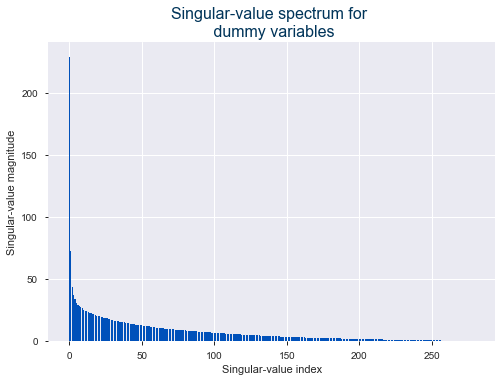

In [25]:
# 🅐 FEATURE ENGINEERING.
# Most of our variables are descriptive variables are categorical. We need to convert
# each of these into "dummy" variables. We then perform dimensional analysis of the result.
# ⓵ Generate a list of categorical variables. We identified variables as such in the
#    "Notes" column of data_dict_populated.  In ⓹ we created a column whose value indicates 
#    categoricals. Here, we simply filter the attribute names by the "Categorical"
#    value in the categoricals.
categoricals = data_dict_populated.set_index(keys = 'cat_vars')\
                                  .loc['categorical', 'attribute']\
                                  .tolist()
for cat_var in categoricals:
    housing_profile = housing_profile.assign(cat_var = lambda Ξ : Ξ[cat_var].astype('category'))

#
# ⓶ Use the pandas.get_dummies() feature to convert the categoricals
#    into dummy variables.
categ_slice = pd.get_dummies(data = housing_profile[categoricals + ['PID']]\
                                                    .assign(MS_SubClass = lambda Ξ : Ξ['MS_SubClass']).astype('category')\
                                                    .set_index(keys = 'PID',
                                                               drop = True),
                              drop_first = True)

cat_sing_vals = np.linalg.svd(a = categ_slice,
                              full_matrices = False,
                              compute_uv = False)
plt.bar(height = cat_sing_vals,
        x = range(len(cat_sing_vals)),
        color = '#0051ba')
plt.xlabel(xlabel = 'Singular-value index')
plt.ylabel(ylabel = 'Singular-value magnitude')
plt.title(label = 'Singular-value spectrum for \n dummy variables',
          fontsize = 16,
          color = '#003459')
plt.savefig(fname = os.path.join('/Users/nhamlett/Documents/GitHub/GA-DSI/project/project_2/Graphics',
                                 'cat_var_singval_spectrum.png'),
            transparent = True)

In [38]:
(np.sum(cat_sing_vals) - np.cumsum(cat_sing_vals))/np.sum(cat_sing_vals)

array([8.96359974e-01, 8.63631078e-01, 8.44022973e-01, 8.27351862e-01,
       8.12135434e-01, 7.98321641e-01, 7.85064898e-01, 7.72056202e-01,
       7.59600009e-01, 7.47390086e-01, 7.36060242e-01, 7.25033476e-01,
       7.14156184e-01, 7.03369859e-01, 6.93027702e-01, 6.82908553e-01,
       6.73035849e-01, 6.63253561e-01, 6.53629313e-01, 6.44285440e-01,
       6.35089029e-01, 6.26055864e-01, 6.17058944e-01, 6.08384583e-01,
       5.99857791e-01, 5.91442827e-01, 5.83084232e-01, 5.74806231e-01,
       5.66652760e-01, 5.58803459e-01, 5.51106585e-01, 5.43588376e-01,
       5.36096476e-01, 5.28740584e-01, 5.21531323e-01, 5.14380320e-01,
       5.07317911e-01, 5.00390415e-01, 4.93525976e-01, 4.86848692e-01,
       4.80269657e-01, 4.73758029e-01, 4.67354918e-01, 4.61096238e-01,
       4.54889501e-01, 4.48739723e-01, 4.42630818e-01, 4.36612293e-01,
       4.30708271e-01, 4.24817688e-01, 4.19016234e-01, 4.13330769e-01,
       4.07742090e-01, 4.02215371e-01, 3.96782356e-01, 3.91363184e-01,
      

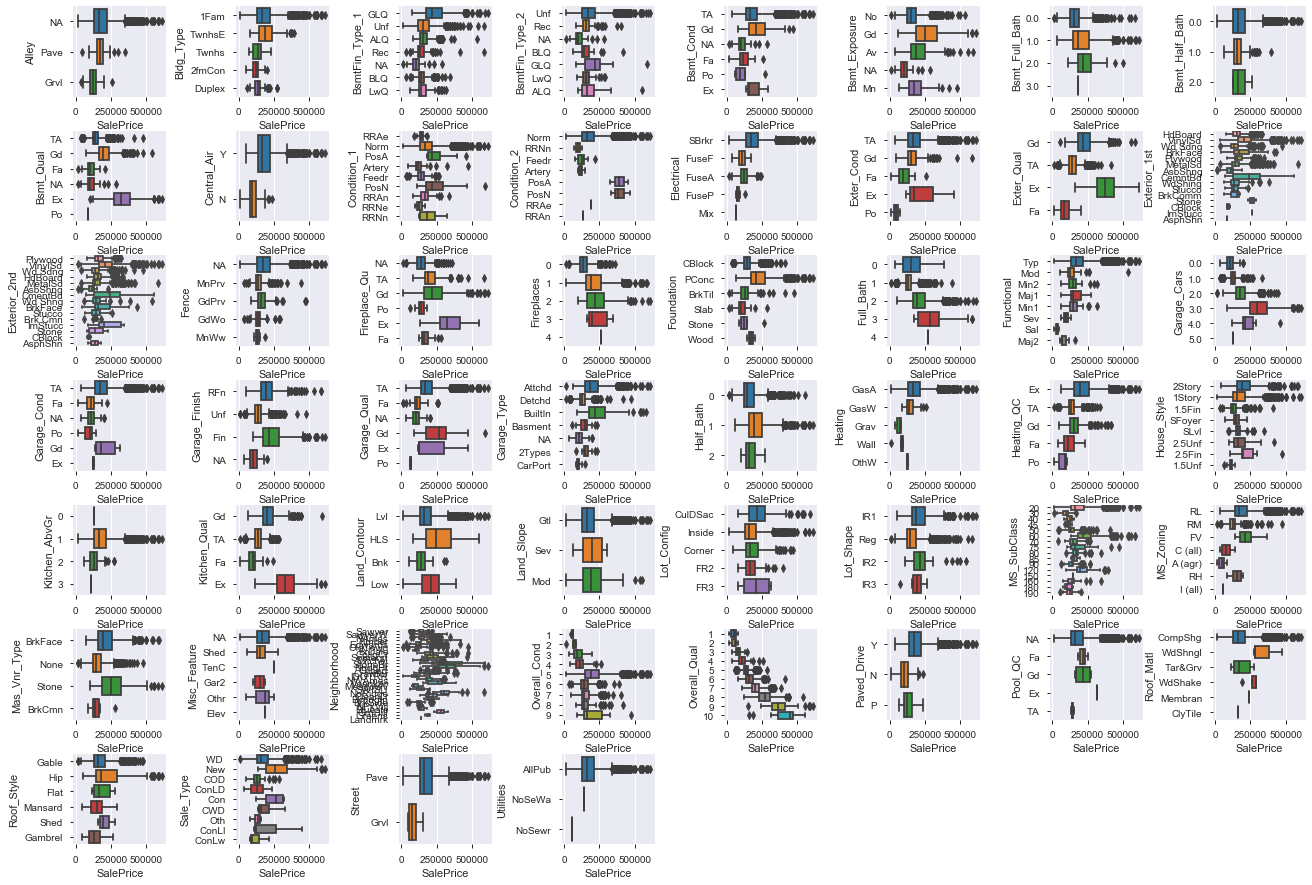

In [8]:
categoricals = data_dict_populated.set_index(keys = 'attribute',
                                             drop = False)\
                                  .sort_index(axis = 0)\
                                  .set_index(keys = 'cat_vars',
                                             drop = False)\
                                  .loc['categorical', 'attribute']\
                                  .tolist()
cat_var = np.random.choice(a = categoricals,
                           size = 1).item(0)

plt.figure(figsize=(25, 20))
plot_grid = gridspec.GridSpec(nrows = int(np.ceil(np.sqrt(len(categoricals))))+1,
                              ncols = int(np.ceil(np.sqrt(len(categoricals))))+1)
plot_grid.update(wspace=0.75, 
                 hspace=0.375)
plot_grid_indices = dict(enumerate(it.product(range(int(np.ceil(np.sqrt(len(categoricals))))),
                                              range(int(np.ceil(np.sqrt(len(categoricals))))))))
    # plot_grid_tuple = list(plot_grid_indices.keys())[0]

    
for cat_var in categoricals:
    plot_grid_tuple = categoricals.index(cat_var)
    ax = plt.subplot(plot_grid[plot_grid_indices.get(plot_grid_tuple)[0]:(plot_grid_indices.get(plot_grid_tuple)[0]+1),
                               plot_grid_indices.get(plot_grid_tuple)[1]:(plot_grid_indices.get(plot_grid_tuple)[1]+1)])

    sns.boxplot(y = cat_var,
                   x = 'SalePrice',
                   ax = ax,
                   orient = 'h',
                   data = housing_profile[[cat_var, 'SalePrice']])


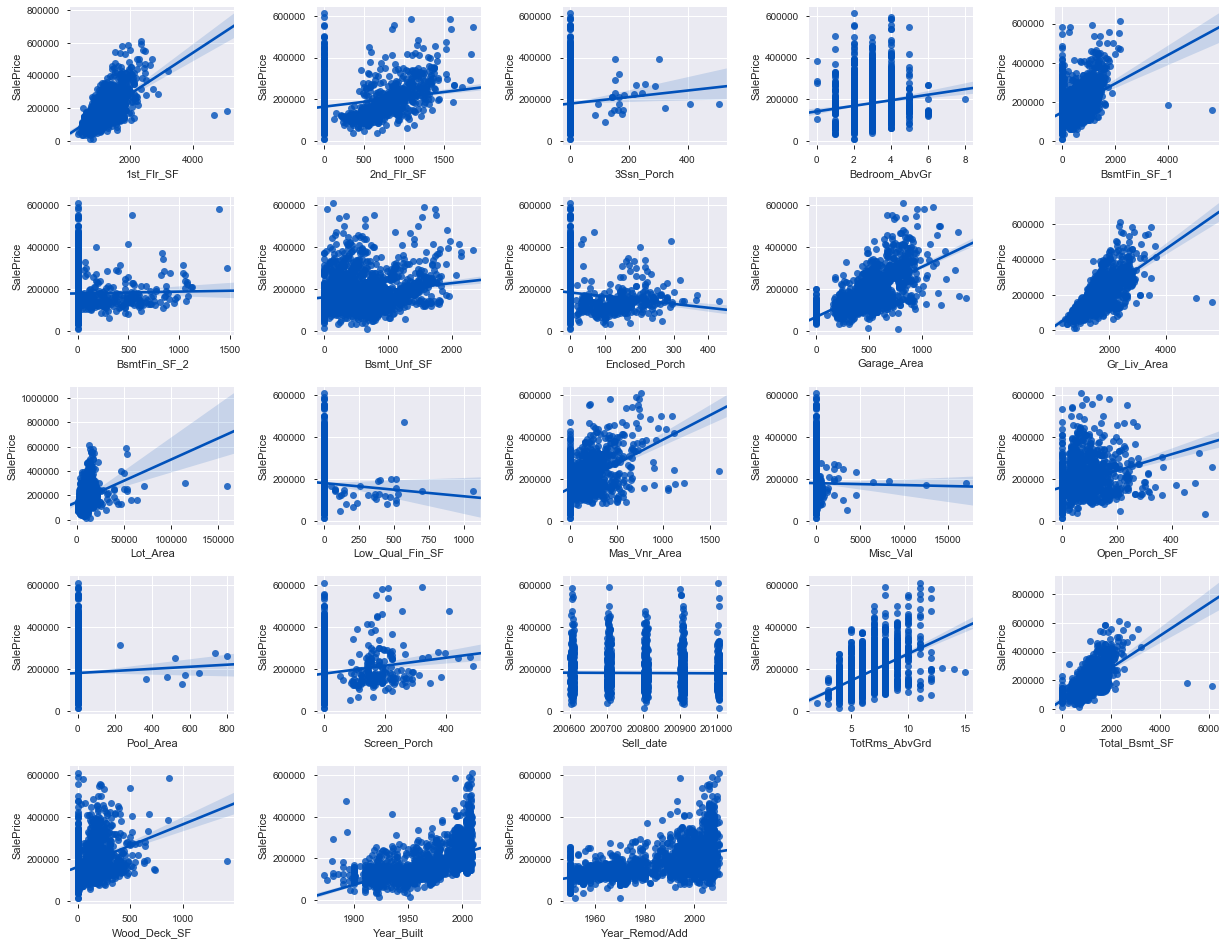

In [28]:
numericals = data_dict_populated.set_index(keys = 'attribute',
                                                  drop = False)\
                                .drop(labels = ['Id', 'PID', 'SalePrice'] +\
                                                discarded_attributes)\
                                .sort_index()\
                                .set_index(keys = 'cat_vars',
                                           drop = False)\
                                .loc['numeric', 'attribute']\
                                .tolist()


plt.figure(figsize=(25, 20))
plot_grid = gridspec.GridSpec(nrows = int(np.ceil(np.sqrt(len(numericals))))+1,
                              ncols = int(np.ceil(np.sqrt(len(numericals))))+1)
plot_grid.update(wspace=0.5, 
                 hspace=0.375)
plot_grid_indices = dict(enumerate(it.product(range(int(np.ceil(np.sqrt(len(numericals))))),
                                              range(int(np.ceil(np.sqrt(len(numericals))))))))

num_var_slopes = dict()
    
for num_var in numericals:
    plot_grid_tuple = numericals.index(num_var)
    ax = plt.subplot(plot_grid[plot_grid_indices.get(plot_grid_tuple)[0]:(plot_grid_indices.get(plot_grid_tuple)[0]+1),
                               plot_grid_indices.get(plot_grid_tuple)[1]:(plot_grid_indices.get(plot_grid_tuple)[1]+1)])
    
    attr_price_pair = housing_profile[[num_var, 'SalePrice']]\
                                     .dropna(axis = 0)
    if num_var == 'Date_sold':
        attr_price_pair = attr_price_pair.assign(Date_sold = [date2num(sell_date)
                                                              for sell_date in attr_price_pair['Date_sold']])
    
    price_from_attr = LinearRegression()
    price_from_attr.fit(X = attr_price_pair[[num_var]],
                        y = attr_price_pair['SalePrice'])
    
    num_var_slopes.update({num_var : price_from_attr.coef_.item(0)})
    sns.regplot(x = num_var,
                y = 'SalePrice',
                ax = ax,
                data = housing_profile[[num_var, 'SalePrice']],
                color = '#0051ba')

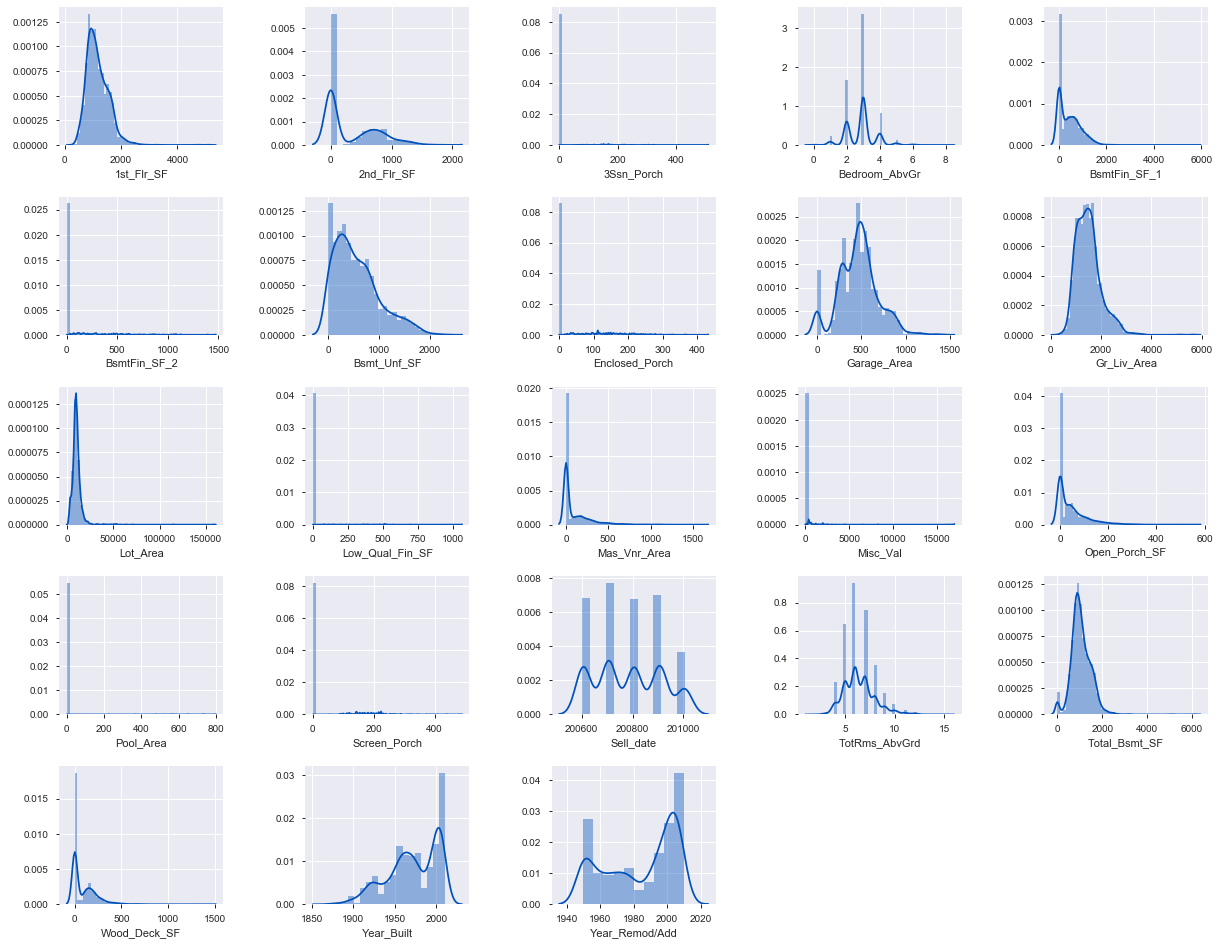

In [29]:
numericals = data_dict_populated.set_index(keys = 'attribute',
                                                  drop = False)\
                                .drop(labels = ['Id', 'PID', 'SalePrice'] +\
                                                discarded_attributes)\
                                .sort_index()\
                                .set_index(keys = 'cat_vars',
                                           drop = False)\
                                .loc['numeric', 'attribute']\
                                .tolist()



plt.figure(figsize=(25, 20))
plot_grid = gridspec.GridSpec(nrows = int(np.ceil(np.sqrt(len(numericals))))+1,
                              ncols = int(np.ceil(np.sqrt(len(numericals))))+1)
plot_grid.update(wspace=0.5, 
                 hspace=0.375)
plot_grid_indices = dict(enumerate(it.product(range(int(np.ceil(np.sqrt(len(numericals))))),
                                              range(int(np.ceil(np.sqrt(len(numericals))))))))

    
for num_var in numericals:
    plot_grid_tuple = numericals.index(num_var)
    attr_price_pair = housing_profile[[num_var]]\
                                     .dropna(axis = 0)

    ax = plt.subplot(plot_grid[plot_grid_indices.get(plot_grid_tuple)[0]:(plot_grid_indices.get(plot_grid_tuple)[0]+1),
                               plot_grid_indices.get(plot_grid_tuple)[1]:(plot_grid_indices.get(plot_grid_tuple)[1]+1)])
    
    sns.distplot(a = attr_price_pair[num_var],
                ax = ax,
                color = '#0051ba')

In [34]:
housing_profile[numericals].describe().T

,count,mean,std,min,25%,50%,75%,max
1st_Flr_SF,2022.0,1162.318002,391.522666,334.0,879.25,1092.0,1401.50,5095.0
2nd_Flr_SF,2022.0,328.382295,425.261226,0.0,0.00,0.0,689.00,1862.0
3Ssn_Porch,2022.0,2.628586,25.408061,0.0,0.00,0.0,0.00,508.0
Bedroom_AbvGr,2022.0,2.843719,0.827118,0.0,2.00,3.0,3.00,8.0
BsmtFin_SF_1,2022.0,442.328882,460.683581,0.0,0.00,368.0,733.00,5644.0
BsmtFin_SF_2,2022.0,48.239367,165.681022,0.0,0.00,0.0,0.00,1474.0
Bsmt_Unf_SF,2022.0,565.241840,443.522453,0.0,220.00,473.5,808.75,2336.0
Enclosed_Porch,2022.0,22.592977,59.811075,0.0,0.00,0.0,0.00,432.0
Garage_Area,2022.0,472.512859,216.009787,0.0,316.25,480.0,576.00,1418.0
Gr_Liv_Area,2022.0,1496.292285,499.339177,334.0,1126.00,1441.5,1728.00,5642.0


In [ ]:
num_var_slopes

<BarContainer object of 23 artists>

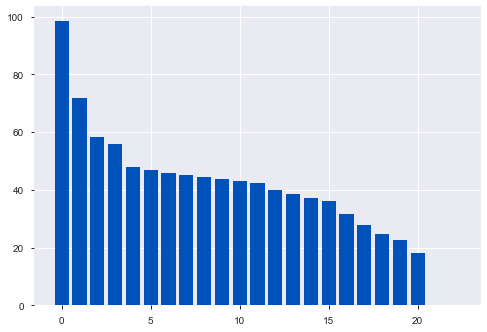

In [33]:
numericals = data_dict_populated.set_index(keys = 'attribute',
                                                  drop = False)\
                                .drop(labels = ['Id', 'PID', 'SalePrice'] +\
                                                discarded_attributes)\
                                .sort_index()\
                                .set_index(keys = 'cat_vars',
                                           drop = False)\
                                .loc['numeric', 'attribute']\
                                .tolist()

num_slice = pd.DataFrame(data = {num_val : (housing_profile[num_val] - housing_profile[num_val].mean())/\
                                            housing_profile[num_val].std()
                                 for num_val in numericals})

num_singvals = np.linalg.svd(a = num_slice.to_numpy(),
                             full_matrices = False,
                             compute_uv = False)
plt.bar(x = range(len(num_singvals)),
        height = num_singvals,
        color = '#0051ba')